In [1]:
import os
import sys
sys.path.append('/home/charis/kul-thesis/OAA/scripts')
import argparse
import numpy as np
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from tools.ai.demo_utils import get_strided_size, get_strided_up_size
import PIL
from core.networks import AffinityNet
from core.datasets import VOC_Dataset_For_Making_CAM, Kvasir_Dataset_For_Making_CAM
from tools.general.io_utils import create_directory
from tools.general.time_utils import Timer
from tools.general.json_utils import read_json
from tools.ai.torch_utils import set_seed, resize_for_tensors, calculate_parameters, load_model, load_ckp

from tools.ai.torch_utils import set_seed, calculate_parameters, load_model
from core.aff_utils import PathIndex, propagate_to_edge

from tools.ai.augment_utils import Normalize

In [2]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_CUBIC):
    dim = None
    (h, w) = image.shape[:2]

    if width is None:
        r = height / float(h)
        dim = (np.ceil(w * r), height)

    else:
        r = width / float(w)
        # print(h, r, h*r, np.ceil(h*r))
        dim = (width, int(np.ceil(h * r)))

    resized = cv2.resize(image, dim, interpolation = inter)

    return resized

parser = argparse.ArgumentParser()

In [3]:
seed = 0
num_workers =12
data_dir = '/home/charis/kul-thesis/kvasir-dataset-v2-new'
scales = '0.5,1.0,1.5,2.0'
architecture='resnet50'
model_name = 'AffinityNet@ResNet50_kvasir@Puzzle'


cam_path = '/home/charis/kul-thesis/OAA/results_kvasir/exp9/results_cam/'
cam_dir = 'ResNet50-kvasir@Puzzle@acc@train@scale=0.5,1.0,1.5,2.0@aff_fg=0.40_bg=0.10/'
domain = 'train'
beta = 10
exp_times = 8
data_dir = '/home/charis/kul-thesis/kvasir-dataset-v2-new/'

In [4]:
experiment_name = model_name

if 'train' in domain:
    experiment_name += '@train'
else:
    experiment_name += '@val'

experiment_name += '@beta=%d'%beta
experiment_name += '@exp_times=%d'%exp_times
# experiment_name += '@threshold=%.2f'%threshold
experiment_name += '@rw'

# cam_dir = f'./experiments/predictions/{cam_dir}/'
pred_dir = create_directory(f'./experiments/predictions/{experiment_name}/')

model_path = './experiments/models/' + f'{model_name}.pth'

set_seed(seed)
log_func = lambda string='': print(string)

In [5]:
%cd /home/charis/kul-thesis/OAA/scripts

/home/charis/kul-thesis/OAA/scripts


In [6]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
normalize_fn = Normalize(imagenet_mean, imagenet_std)

meta_dic = read_json('/home/charis/kul-thesis/OAA/scripts/data_kvasir/kvasir.json')
dataset = Kvasir_Dataset_For_Making_CAM(data_dir, domain)

###################################################################################
# Network
###################################################################################
path_index = PathIndex(radius=10, default_size=(512 // 4, 512 // 4))
model = AffinityNet(architecture, path_index)

model = model.cuda()
model.eval()

log_func('[i] Architecture is {}'.format(architecture))
log_func('[i] Total Params: %.2fM'%(calculate_parameters(model)))
log_func()

try:
    use_gpu = os.environ['CUDA_VISIBLE_DEVICES']
except KeyError:
    use_gpu = '0'

the_number_of_gpu = len(use_gpu.split(','))
the_number_of_gpu = 0
if the_number_of_gpu > 1:
    log_func('[i] the number of gpu : {}'.format(the_number_of_gpu))
    model = nn.DataParallel(model)

load_model(model, model_path, parallel=the_number_of_gpu > 1)

[i] Architecture is resnet50
[i] Total Params: 23.63M



In [7]:
eval_timer = Timer()
scales = [float(scale) for scale in scales.split(',')]


In [8]:
for step, (ori_image, image_id, label, gt_mask) in enumerate(dataset):
        ori_w, ori_h = ori_image.size
        npy_path = pred_dir + image_id + '.npy'
        break
cam_dict_arr = np.load(cam_path + image_id.split('/')[-1] + '.npy', allow_pickle=True).item()

In [13]:
scales

[0.5, 1.0, 1.5, 2.0]

In [9]:
cam_dict_arr[0].shape


(576, 720)

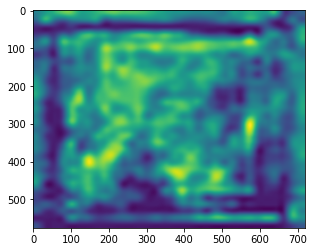

In [11]:
import matplotlib.pyplot as plt
plt.imshow(cam_dict_arr[0])

In [10]:
with torch.no_grad():
    length = len(dataset)
    for step, (ori_image, image_id, label, gt_mask) in enumerate(dataset):
        ori_w, ori_h = ori_image.size

        npy_path = pred_dir + image_id + '.npy'
        if os.path.isfile(npy_path):
            continue
        cam_dict_arr = np.load(cam_path + image_id.split('/')[-1] + '.npy', allow_pickle=True)
        cam_dict = cam_dict_arr[()]

        keys_temp = list(cam_dict.keys())
        keys = [0]
        for item in keys_temp:
            keys.append(item+1)
        keys = np.array(keys)
        strided_size = get_strided_size((ori_h, ori_w), 4)
        strided_up_size = get_strided_up_size((ori_h, ori_w), 16)
        t = []
        

        # preprocessing
        image = np.asarray(ori_image)
        image = normalize_fn(image)
        image = image.transpose((2, 0, 1))

        image = torch.from_numpy(image)
        flipped_image = image.flip(-1)

        images = torch.stack([image, flipped_image])
        # images = images.cuda()

        # inference
        edge = model.get_edge(images)
        print(type(edge), edge.shape)

        for i, key in enumerate(cam_dict.keys()):
                # print(cam_file[key].shape)
                t.append(cv2.resize(cam_dict[key], (edge.shape[1], edge.shape[0]), interpolation = cv2.INTER_CUBIC))
        cams = np.stack(t, axis=0)
        print(cams.shape)

        # postprocessing
        # cam_dict = np.load(cam_path + image_id.split('/')[-1] + '.npy', allow_pickle=True).item()
        cam_downsized_values = torch.from_numpy(cams)

        print(cam_downsized_values.shape)
        rw = propagate_to_edge(cam_downsized_values, edge, beta=beta, exp_times=exp_times, radius=5)
        
        rw_up = F.interpolate(rw, scale_factor=4, mode='bilinear', align_corners=False)[..., 0, :ori_h, :ori_w]
        rw_up = rw_up / torch.max(rw_up)
        
        np.save(npy_path, {"keys": cam_dict['keys'], "rw": rw_up.cpu().numpy()})
        
        sys.stdout.write('\r# Make CAM with Random Walk [{}/{}] = {:.2f}%, ({}, rw_up={}, rw={})'.format(step + 1, length, (step + 1) / length * 100, (ori_h, ori_w), rw_up.size(), rw.size()))
        sys.stdout.flush()
    print()

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor